In [1]:
import os
cwd = os.getcwd().replace('/reinforcement_learning', '')
os.chdir(cwd)

In [2]:
from dataset import Dataset
import gym
import gym_anytrading
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3 import A2C, PPO, SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import quantstats as qs


In [3]:
data_binance = Dataset().get_data(days=90, ticker='BTCUSDT', ts='5m')

In [4]:
df = data_binance.copy()[['open', 'high', 'low', 'close', 'volume']]
df = df.reset_index()
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df.set_index('Date')

In [5]:
window_size = 50
start_index = window_size
end_index = len(df)
num_cpu = os.cpu_count()


def create_env(df, start_index, end_index, window_size):
    env = gym.make('forex-v0', df=df,  frame_bound=(start_index,
                   end_index), window_size=window_size)
    env.trade_fee = 0
    return env


def env_maker():
    return create_env(df, start_index, end_index, window_size)


env = make_vec_env(
    lambda: env_maker(),
    n_envs=num_cpu,
    seed=0,
    vec_env_cls=DummyVecEnv
)


In [8]:
model = PPO('MlpPolicy', env, verbose=1, tensorboard_log="./tensorboard_logs/")
model.learn(total_timesteps=2500000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard_logs/PPO_4
-----------------------------
| time/              |      |
|    fps             | 1001 |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 807           |
|    iterations           | 2             |
|    time_elapsed         | 5             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 3.6226207e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.693        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.38e+12      |
|    n_updates            | 10            |

info {'total_reward': -82392799.99999891, 'total_profit': 1.0688173390271651, 'position': 0}


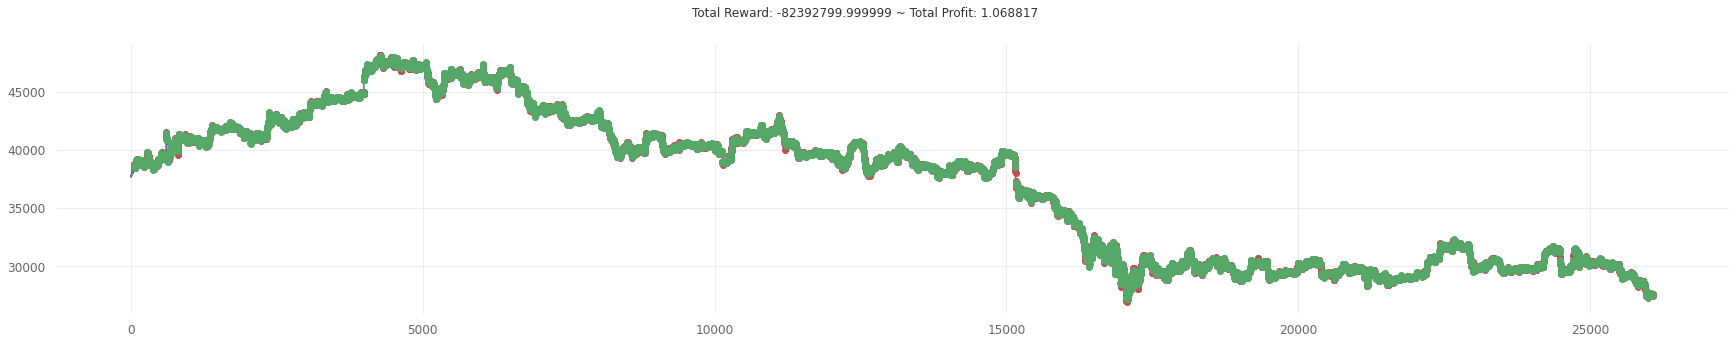

In [7]:
env = gym.make('forex-v0', df=df, frame_bound=(start_index,
               end_index), window_size=window_size)
env.trade_fee = 0

obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, state = model.predict(obs)
    obs, reward, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(30, 5))
# plt.cla()
env.render_all()
plt.show()


                           Strategy
-------------------------  ----------
Start Period               2022-03-14
End Period                 2022-06-12
Risk-Free Rate             0.0%
Time in Market             19.0%

Cumulative Return          49.49%
CAGR﹪                     410.69%

Sharpe                     0.15
Prob. Sharpe Ratio         93.75%
Smart Sharpe               0.15
Sortino                    0.24
Smart Sortino              0.24
Sortino/√2                 0.17
Smart Sortino/√2           0.17
Omega                      1.08

Max Drawdown               -15.83%
Longest DD Days            53
Volatility (ann.)          2.79%
Calmar                     25.95
Skew                       3.08
Kurtosis                   176.21

Expected Daily %           0.0%
Expected Monthly %         10.57%
Expected Yearly %          49.49%
Kelly Criterion            3.73%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.29%
Expected Shortfall (cVaR)  -0.29%

Max Consecutive Wins    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-03-14,2022-04-26,2022-05-06,53,-15.825707,-15.126237
2,2022-05-10,2022-05-11,2022-05-11,0,-8.887612,-8.659552
3,2022-05-12,2022-05-13,2022-05-14,2,-8.223659,-8.212735
4,2022-05-27,2022-06-06,2022-06-08,11,-8.088815,-7.581085
5,2022-05-14,2022-05-23,2022-05-26,11,-7.244662,-6.924526


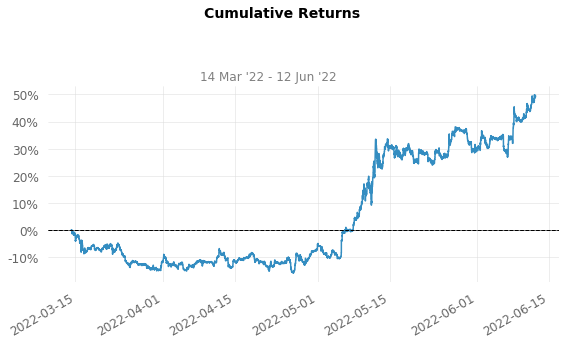

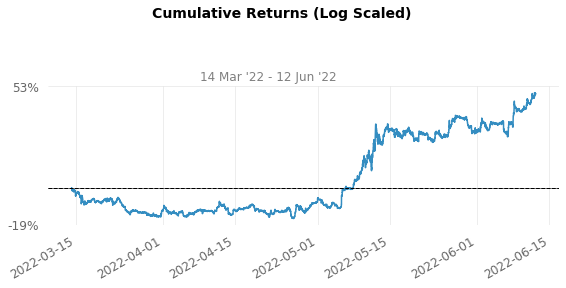

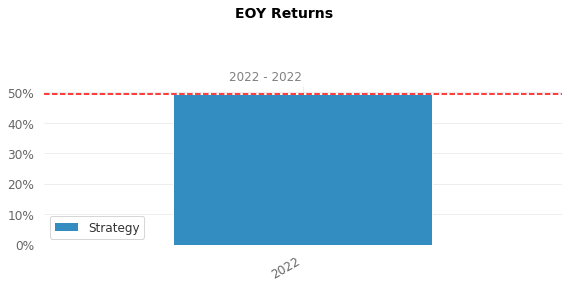

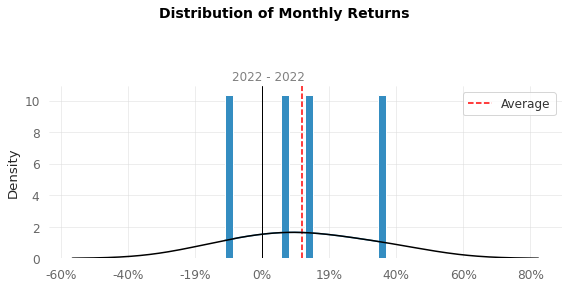

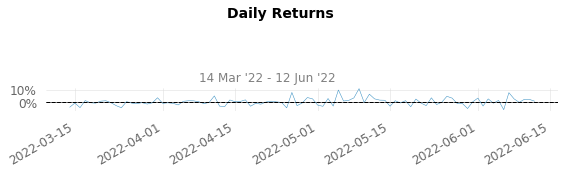

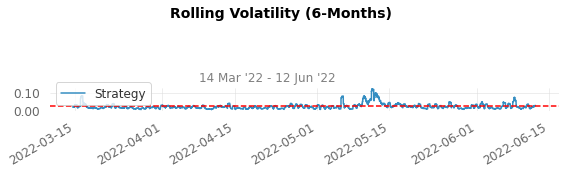

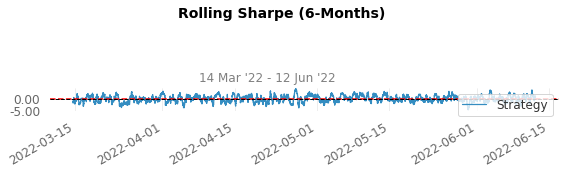

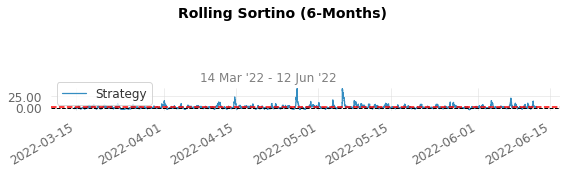

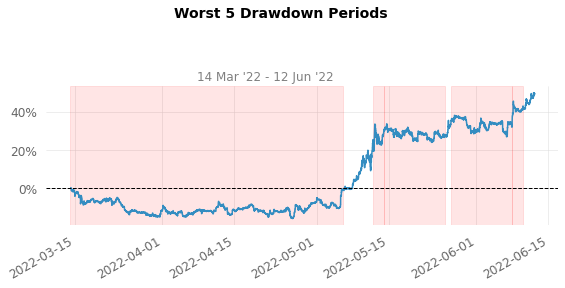

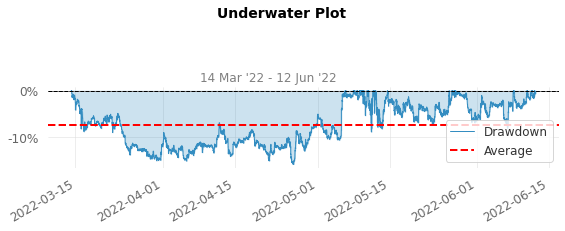

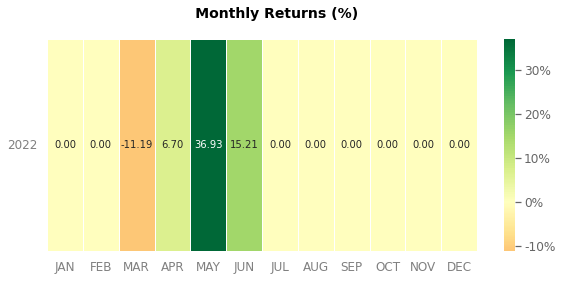

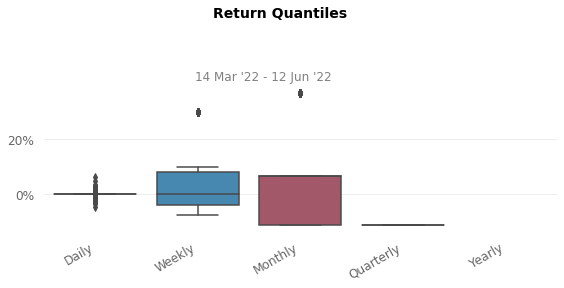

In [39]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
# qs.reports.html(returns, output='reinforcement_learning/a2c_quantstats.html')
